In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

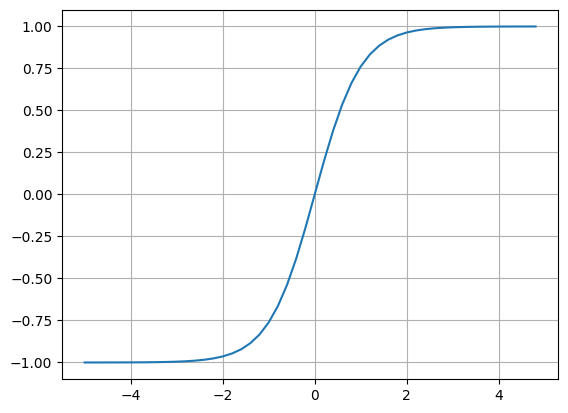

In [4]:
# show tanh graph
x = np.arange(-5, 5, 0.2)
y = np.tanh(x)
plt.plot(x, y)
plt.grid()

In [10]:
from graphviz import Digraph
def trace(root): # using dfs to build a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes: # only add each node once
            nodes.add(v)
            for child in v._prev: # traverse each child only once
                edges.add((child, v)) # from child to parent
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR means left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{%s | %s | data %.2f | grad %.2f}" % (n._op, n.label, n.data, n.grad), shape='record')
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))
    return dot

class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # for printing
        return f"Value(data={self.data})"

    def __add__(self, other): # a + b 
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other): # a * b
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        return Value(t, (self, ), 'tanh')

In [3]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
xw_sum = x1w1 + x2w2; xw_sum.label = 'x1w1+x2w2'
n = xw_sum + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



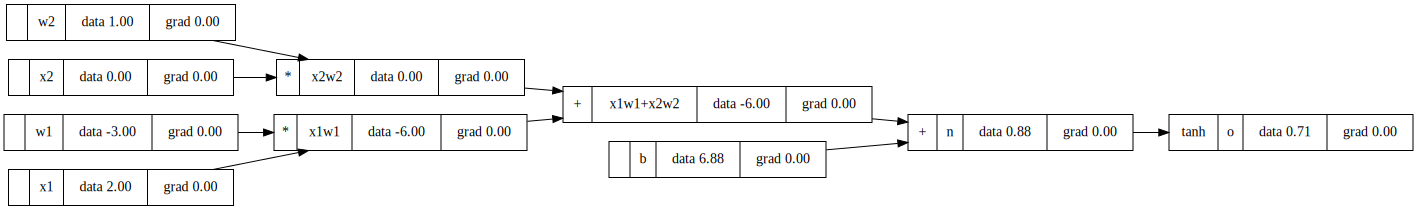

In [4]:
draw_dot(o)

In [15]:
# let's compute derivatives
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2 = 0.5
n.grad = 1 - o.data**2
print(n.grad)
n.grad = 0.5

0.4999999999999999


In [29]:
xw_sum.grad = n.grad * 1.0 # dn/d(xw_sum) = 0.5
b.grad = n.grad * 1.0 # 0.5
x1w1.grad = xw_sum.grad * 1.0 # 0.5
x2w2.grad = xw_sum.grad * 1.0 # 0.5

w1.grad = x1w1.grad * x1.data # 0.5 * 0.0 = 0.0
w2.grad = x2w2.grad * x2.data # 0.5 * 2.0 = 1.0

x1.grad = x1w1.grad * w1.data # 0.5 * -3.0 = -1.5
x2.grad = x2w2.grad * w2.data # 0.5 * 1.0 = 0.5

In [2]:
# add backward functions
from graphviz import Digraph
def trace(root): # using dfs to build a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes: # only add each node once
            nodes.add(v)
            for child in v._prev: # traverse each child only once
                edges.add((child, v)) # from child to parent
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR means left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{%s | %s | data %.2f | grad %.2f}" % (n._op, n.label, n.data, n.grad), shape='record')
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))
    return dot

class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # default: no action for leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # for printing
        return f"Value(data={self.data})"

    def __add__(self, other): # a + b 
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad = out.grad * 1.0
            other.grad = out.grad * 1.0
        out._backward = _backward
        return out

    def __mul__(self, other): # a * b
        out = Value(self.data * other.data, (self, other), '*')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = out.grad * (1 - t**2)
        out._backward = _backward
        return out

In [32]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
xw_sum = x1w1 + x2w2; xw_sum.label = 'x1w1+x2w2'
n = xw_sum + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

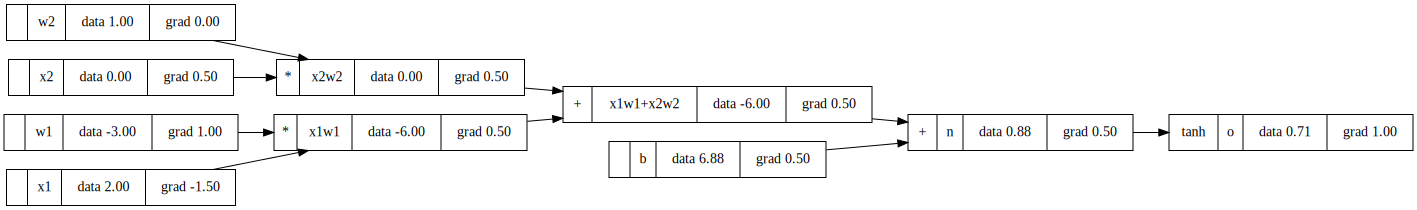

In [5]:
o.grad = 1.0
o._backward()
n._backward()
b._backward() # None. Nothing will happen
xw_sum._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()
draw_dot(o)

In [6]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

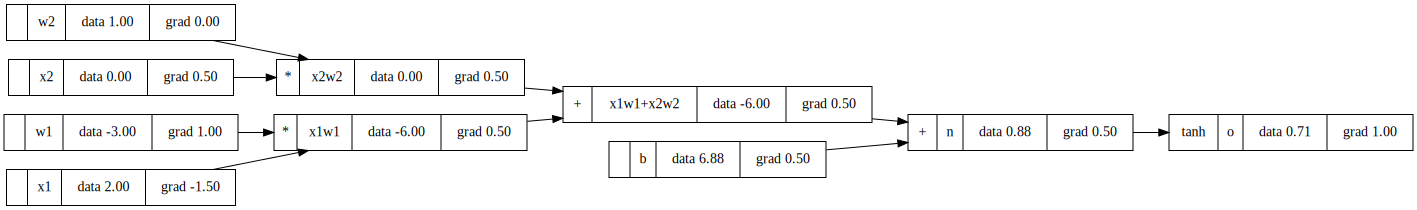

In [7]:
draw_dot(o)

In [10]:
# add backward()
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # default: no action for leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # for printing
        return f"Value(data={self.data})"

    def __add__(self, other): # a + b 
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad = out.grad * 1.0
            other.grad = out.grad * 1.0
        out._backward = _backward
        return out

    def __mul__(self, other): # a * b
        out = Value(self.data * other.data, (self, other), '*')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = out.grad * (1 - t**2)
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

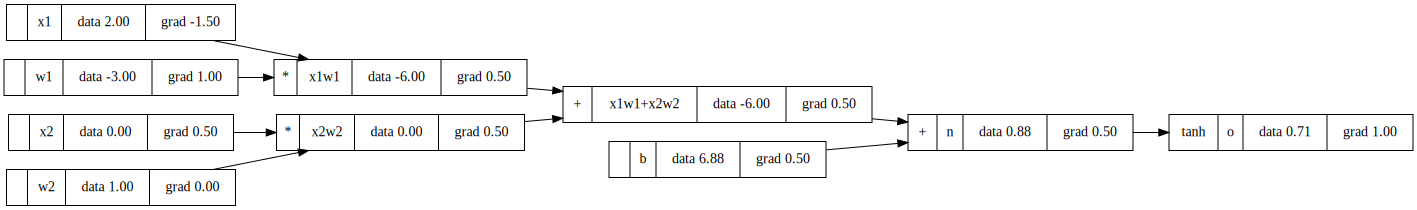

In [11]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
xw_sum = x1w1 + x2w2; xw_sum.label = 'x1w1+x2w2'
n = xw_sum + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

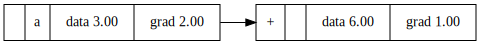

In [16]:
# there is a bug. see this example
a = Value(3.0, label='a')
b = a + a
b.backward()
draw_dot(b)

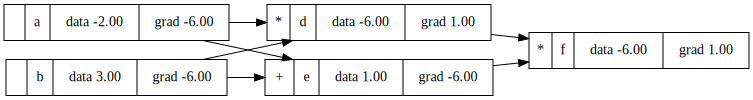

In [13]:
# here is another example
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [14]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # default: no action for leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # for printing
        return f"Value(data={self.data})"

    def __add__(self, other): # a + b 
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out

    def __mul__(self, other): # a * b
        out = Value(self.data * other.data, (self, other), '*')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

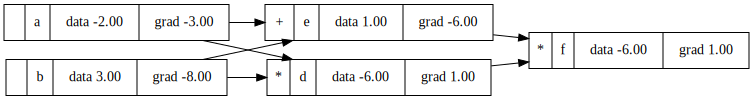

In [15]:
# here is another example
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)